In [1]:
%matplotlib inline


import librosa
import librosa.display

import pandas
import numpy
import sklearn
import sklearn.model_selection

from scipy import ndimage
from scipy import signal

import IPython

import matplotlib.pyplot as plt

In [2]:
labels = pandas.read_csv('data/ff1010bird.labels.csv', index_col='itemid')
labels.head(3)

,datasetid,hasbird
itemid,,
64486,ff1010bird,0
2525,ff1010bird,0
44981,ff1010bird,0


In [3]:
len(labels), labels.hasbird.mean()

(7690, 0.2516254876462939)

In [4]:
pos = labels[labels.hasbird == 1].head(10)
neg = labels[labels.hasbird == 0].head(10)
v = neg.index.values
'{{{}}}'.format(','.join(str(i) for i in v))

'{64486,2525,44981,101323,165746,38232,104540,157473,132129,127302}'

In [5]:
def features(wavpath):
    y, sr = librosa.load(wavpath, offset=0)
    print(sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=2048, hop_length=512, n_mfcc=20)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=500, fmax=8000)
    return mel

def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
def plot_melspectrogram(S, title='Mel spectrogram', fmax=8000):
    plt.figure(figsize=(10, 4))
    d = librosa.power_to_db(S, ref=numpy.max)
    librosa.display.specshow(d, y_axis='mel', x_axis='time', fmin=500, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

def meansub(s):
    return s - (numpy.mean(s, axis=0) + 1e-8)


19037 64486
22050
22050


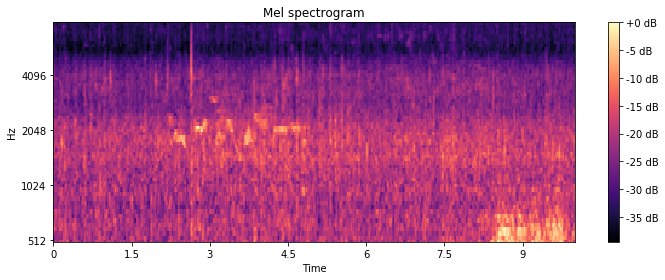

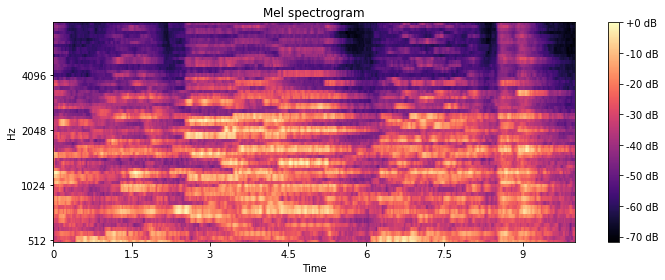

In [6]:
p = pos.index.values[0]
n = neg.index.values[0]
print(p, n)
p = features('data/ff1010bird/{}.wav'.format(p))
n = features('data/ff1010bird/{}.wav'.format(n))

#plot_mfcc(p)
#plot_mfcc(n)
plot_melspectrogram(p)
plot_melspectrogram(n)

IPython.display.Audio('data/ff1010bird/{}.wav'.format(pos.index.values[0]))

ref (64, 429)
ours (64, 429)
ratio 1678.5656058724958
13.873852526361897 0.0082653025 13.873854


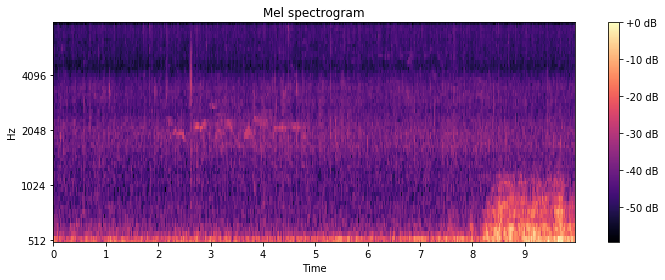

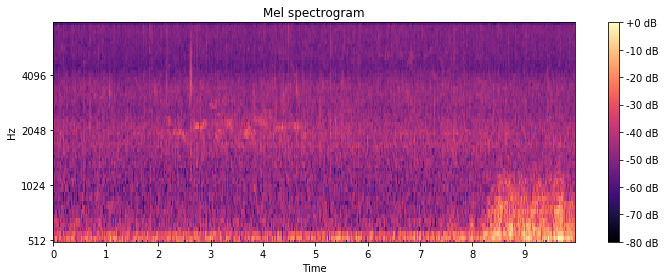

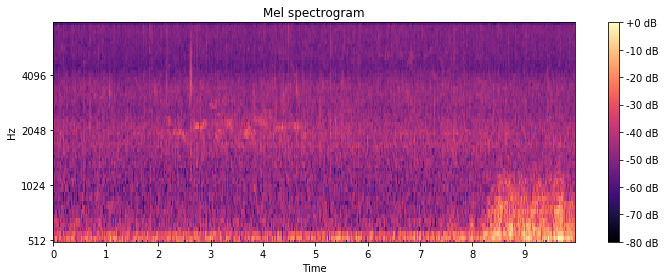

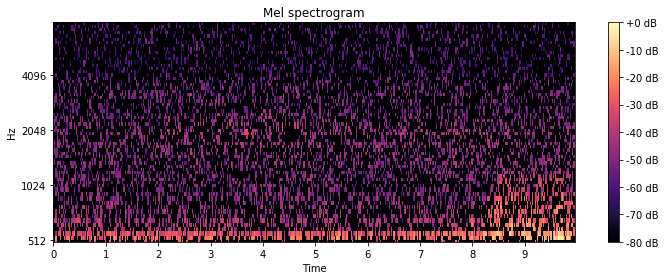

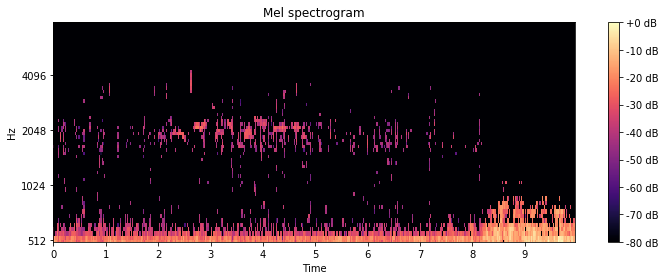

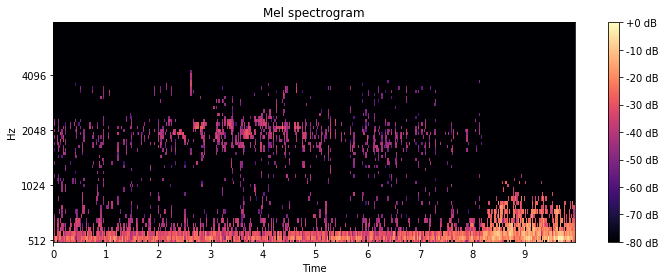

In [7]:
import detectbirds

def melspec(y, sr, n_fft=2048, hop_length=None, win_length=None, n_mels=128, fmin=0, fmax=None):
    if hop_length is None:
        hop_length = n_fft//2
    if win_length is None:
        win_length = n_fft
    if fmax is None:
        fmax = sr//2
        
    frames = librosa.util.frame(y, frame_length=n_fft, hop_length=hop_length)
    spec_frames = []
    for frame_no in range(frames.shape[1]):
        frame = frames[:,frame_no]
        assert frame.shape[0] == n_fft

        s = detectbirds.melspectrogram(frame, n_mels, fmin, fmax, n_fft, sr) 
        
        s = s.reshape(-1, 1)
        spec_frames.append(s)
        
    mels = numpy.hstack(spec_frames)
    assert mels.shape[1] == frames.shape[1], (mels.shape,frames.shape)
    return mels

y, sr = librosa.load('data/ff1010bird/{}.wav'.format(19037), offset=0)
r = librosa.feature.melspectrogram(y, sr, fmin=0, fmax=None, n_fft=1024, n_mels=64, norm=None, htk=True)
r = r[:,1:-1]
print('ref', r.shape)
s = melspec(y, sr, n_fft=1024, fmin=0, fmax=None, n_mels=64)
print('ours', s.shape)

rm = numpy.mean(r)
sm = numpy.mean(s)

n = s / sm * rm
nm = numpy.mean(n)
print('ratio', rm/sm)
print(rm, sm, nm)

plot_melspectrogram(r)
plot_melspectrogram(s)
plot_melspectrogram(n)
plot_melspectrogram(n-r)
plot_melspectrogram(meansub(r))
plot_melspectrogram(meansub(n))



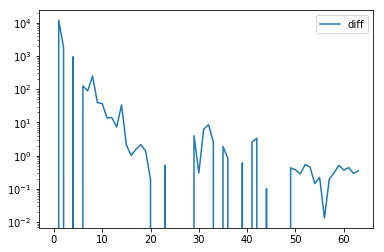

In [16]:
import features
rr = features.melspec_maxp(r)
nn = features.melspec_maxp(n)
pandas.DataFrame({
    #'ref': rr,
    #'ours': nn,
    'diff': nn-rr,
}).plot(logy=True)

In [9]:
m  = numpy.mean(r, axis=0)
m.shape

(429,)

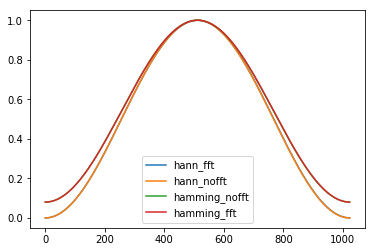

In [10]:
df = pandas.DataFrame({
    'hann_fft': librosa.filters.get_window('hann', 1024, fftbins=True),
    'hann_nofft': librosa.filters.get_window('hann', 1024, fftbins=False),
    'hamming_nofft': librosa.filters.get_window('hamming', 1024, fftbins=False),
    'hamming_fft': librosa.filters.get_window('hamming', 1024, fftbins=True),
})
df.plot()

In [11]:
librosa.filters.get_window('hamming', 1024, fftbins=False).shape

(1024,)

In [12]:
sample_rate = 20050
nfilt = 64
NFFT = 1024

low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    left = int(bin[m - 1])
    center = int(bin[m])
    right = int(bin[m + 1])

    print(m, left, center, right)
    
    for k in range(left, center):
        w = (k - left) / (center - left)
        fbank[m - 1, k] = w
    for k in range(center, right):
        w = (right - k) / (right - center)
        fbank[m - 1, k] = w

print(fbank.shape)
print(fbank[4])
        
#filter_banks = numpy.dot(pow_frames, fbank.T)
#filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
#filter_banks = 20 * numpy.log10(filter_banks)  # dB

1 0 1 3
2 1 3 4
3 3 4 6
4 4 6 8
5 6 8 10
6 8 10 12
7 10 12 14
8 12 14 16
9 14 16 18
10 16 18 21
11 18 21 23
12 21 23 25
13 23 25 28
14 25 28 31
15 28 31 34
16 31 34 37
17 34 37 40
18 37 40 43
19 40 43 47
20 43 47 50
21 47 50 54
22 50 54 58
23 54 58 62
24 58 62 66
25 62 66 70
26 66 70 75
27 70 75 80
28 75 80 85
29 80 85 90
30 85 90 95
31 90 95 101
32 95 101 107
33 101 107 113
34 107 113 119
35 113 119 126
36 119 126 133
37 126 133 140
38 133 140 148
39 140 148 156
40 148 156 164
41 156 164 172
42 164 172 181
43 172 181 191
44 181 191 200
45 191 200 211
46 200 211 221
47 211 221 232
48 221 232 244
49 232 244 256
50 244 256 268
51 256 268 281
52 268 281 295
53 281 295 309
54 295 309 324
55 309 324 339
56 324 339 356
57 339 356 372
58 356 372 390
59 372 390 408
60 390 408 427
61 408 427 447
62 427 447 468
63 447 468 489
64 468 489 512
(64, 513)
[0.  0.  0.  0.  0.  0.  0.  0.5 1.  0.5 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.

### %%timeit
spectrogram(y, n_mels=40, n_fft=512)

In [13]:
%%timeit
librosa.feature.melspectrogram(y, n_mels=64, n_fft=1024)

67.3 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%load_ext line_profiler

In [15]:
%lprun -f spectrogram spectrogram(y)

UsageError: Could not find function 'spectrogram'.
NameError: name 'spectrogram' is not defined
